<h1 style="background-color:#1aff1a;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">We are implementing Machine Learning Algorithms to predict Personality from Text </h1>


<h1 style="background-color:#99b3ff;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Mounting google drive</h1>


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 26 kB/s 


 <h1 style="background-color:#99b3ff;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Libraries used</h1>


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# from sklearn.naive_bayes import MultinomialNB
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingClassifier
# from imblearn.over_sampling import SMOTE

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv('/content/gdrive/My Drive/dataset/mbti_1.csv')
data.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [ ]:
data.describe(include='O')

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'Physical touch, followed by quality time.|||Y...
freq    1832                                                  1

In [ ]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [ ]:
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)
data['words_per_comment'] = data['posts'].apply(lambda x: len(x.split())/50)
data['variance_of_word_counts'] = data['posts'].apply(lambda x: var_row(x))
data['question_per_comment'] = data['posts'].apply(lambda x: x.count('?')/50)
data['excl_per_comment'] = data['posts'].apply(lambda x: x.count('!')/50)
data['ellipsis_per_comment'] = data['posts'].apply(lambda x: x.count('...')/50)

data.head()

type  ... ellipsis_per_comment
0  INFJ  ...                 0.30
1  ENTP  ...                 0.38
2  INTP  ...                 0.26
3  INTJ  ...                 0.52
4  ENTJ  ...                 0.42

[5 rows x 8 columns]

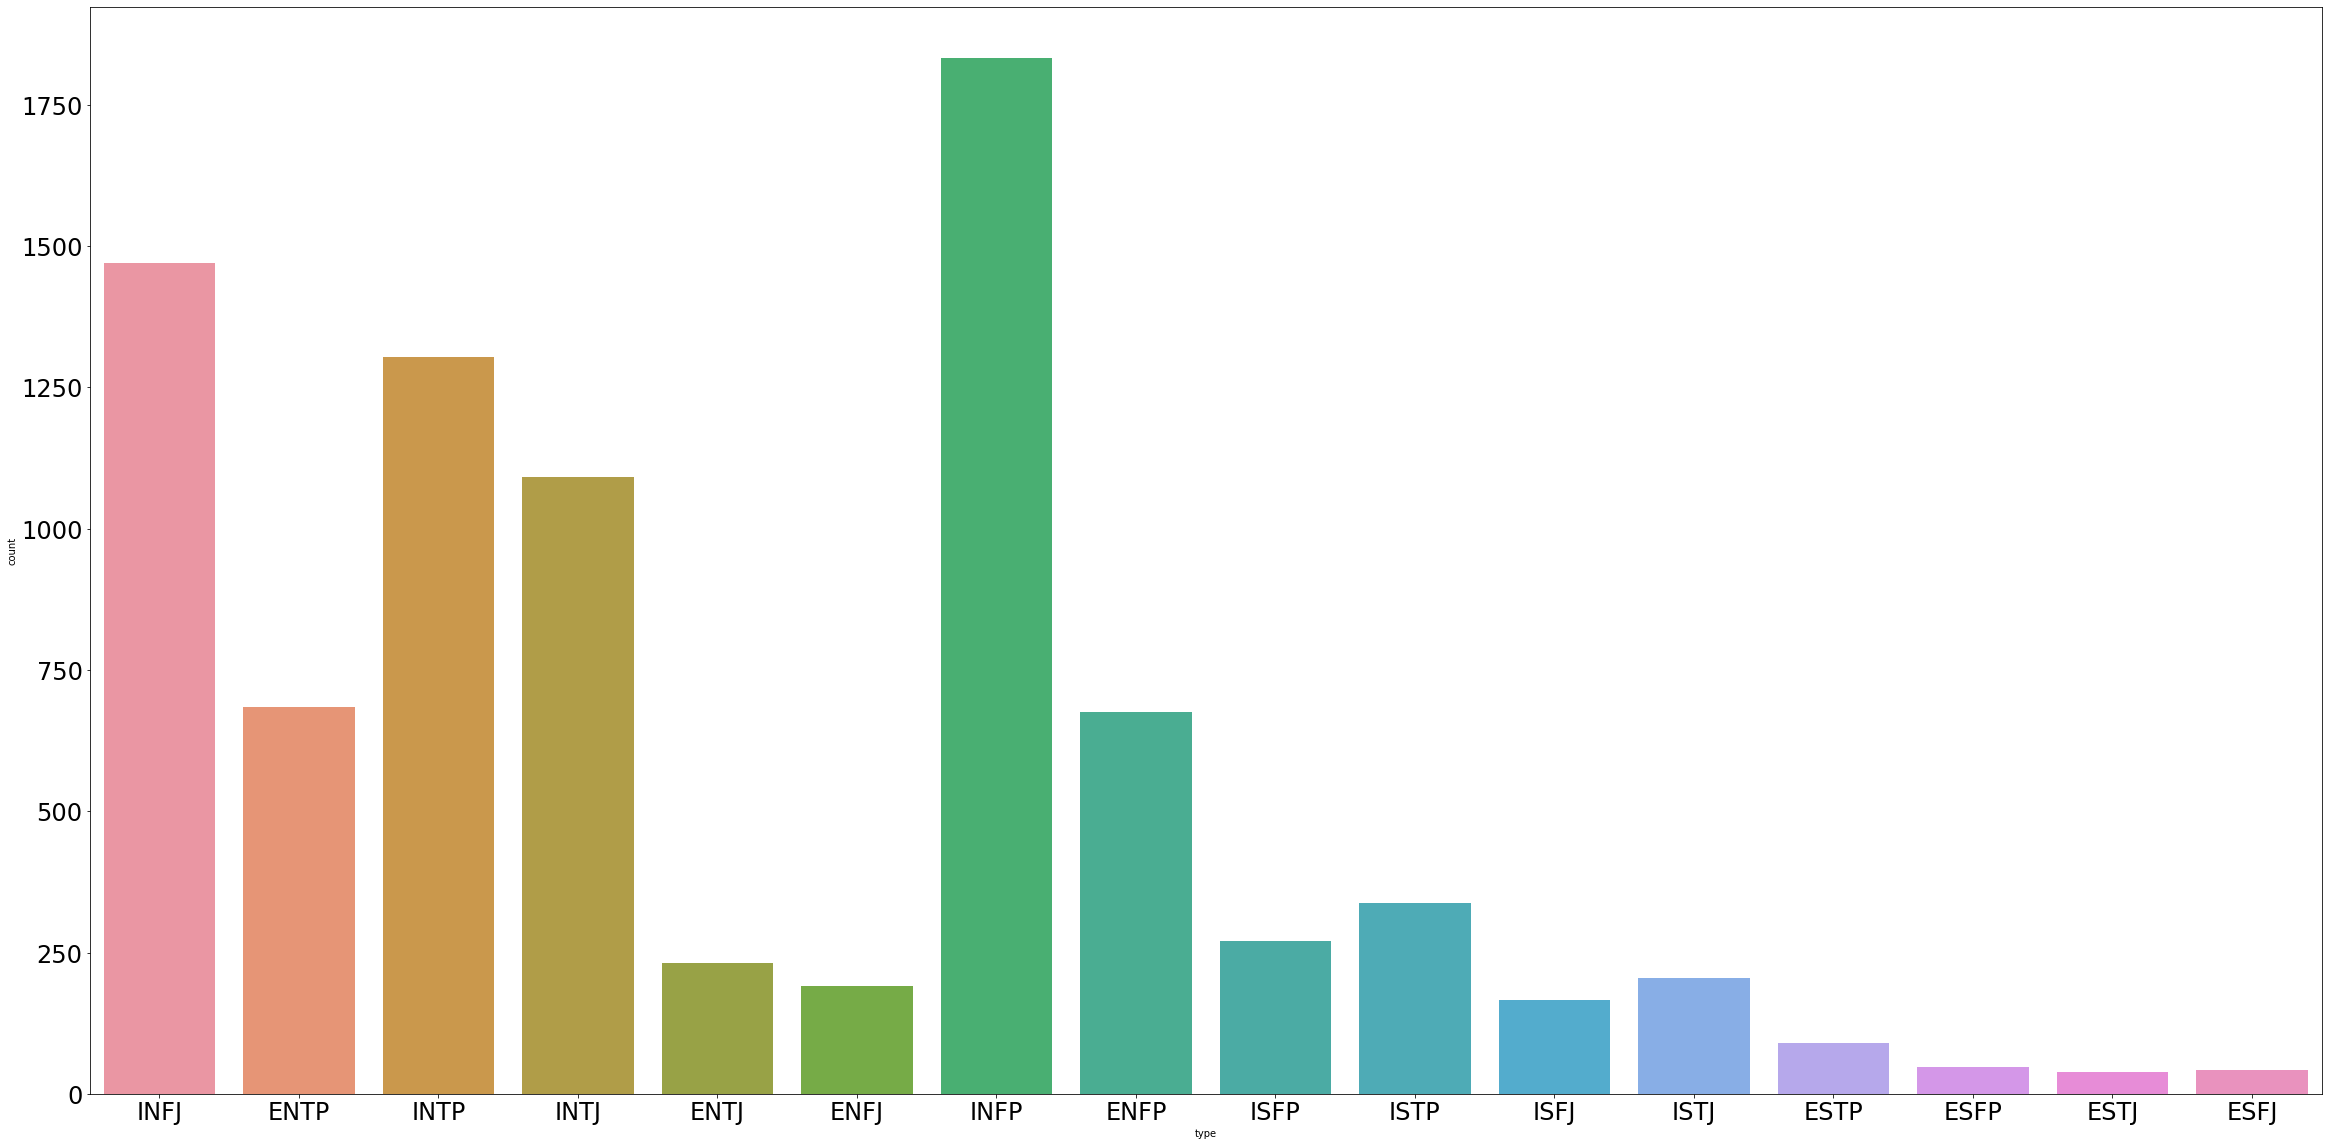

In [ ]:
plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=data, x='type')

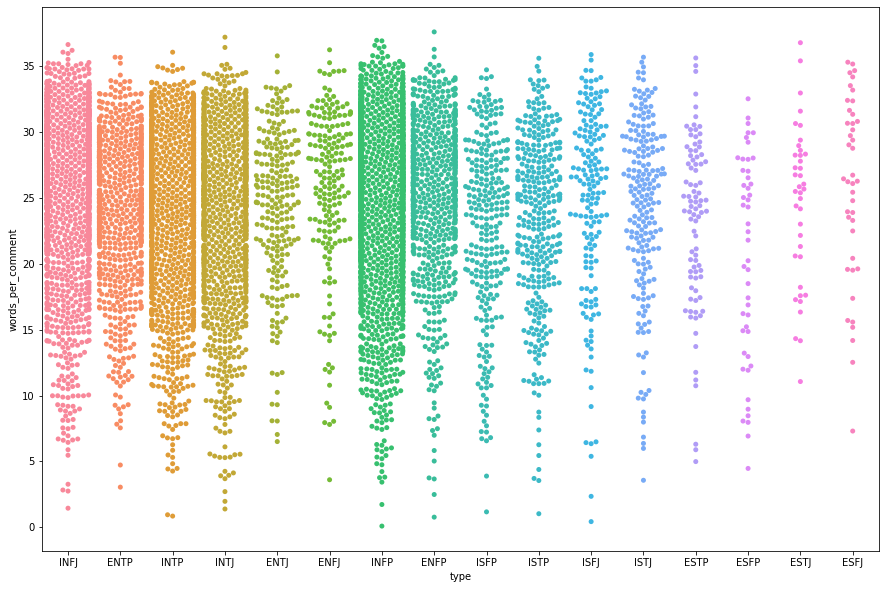

In [ ]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=data)

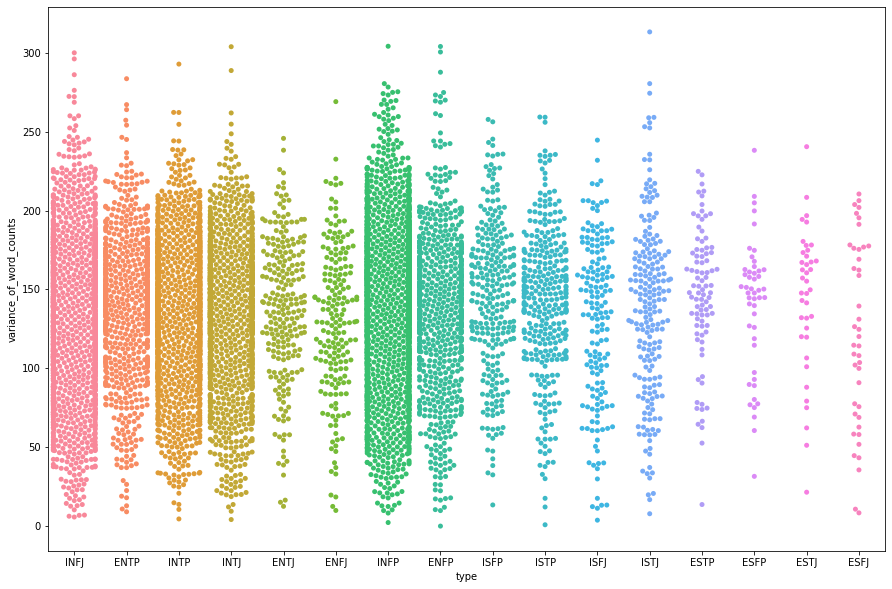

In [ ]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "variance_of_word_counts", data=data)

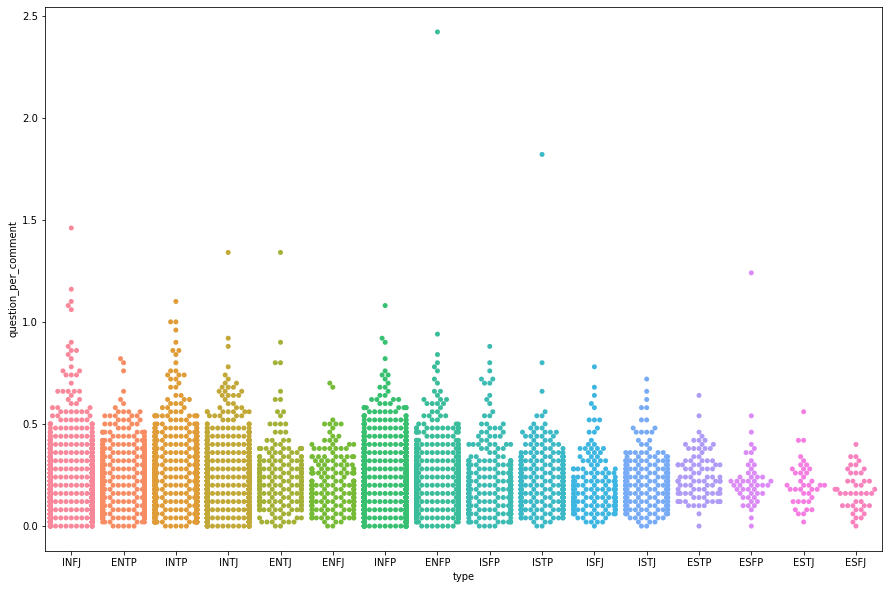

In [ ]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "question_per_comment", data=data)

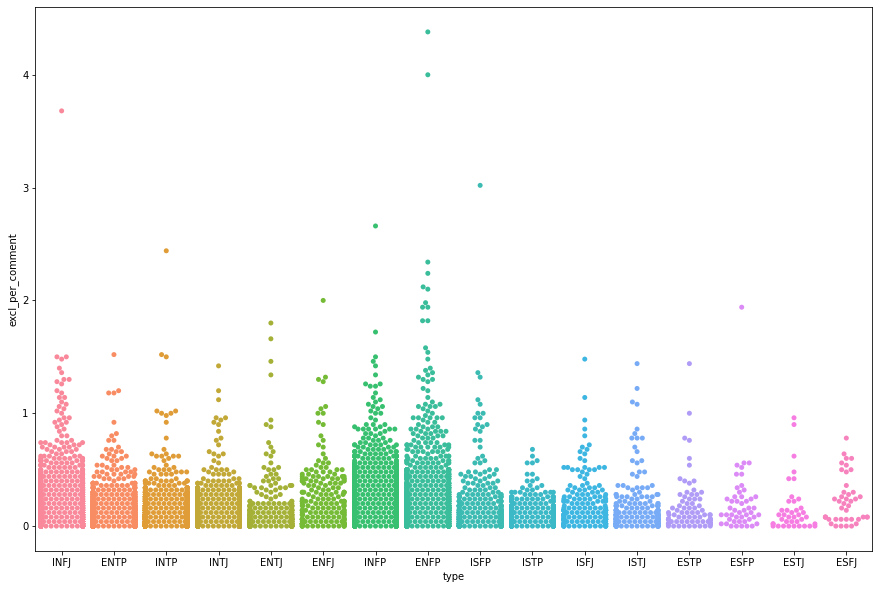

In [ ]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "excl_per_comment", data=data)

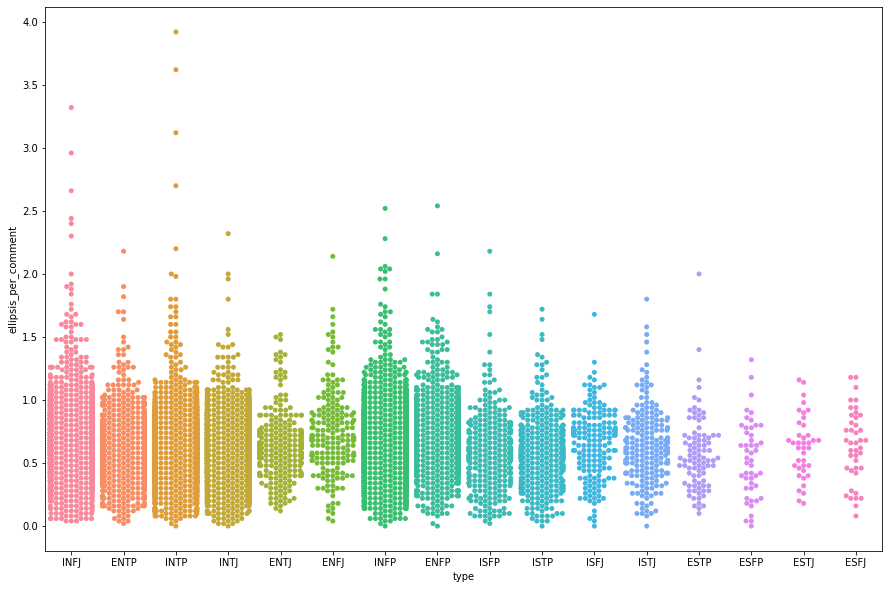

In [ ]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "ellipsis_per_comment", data=data)

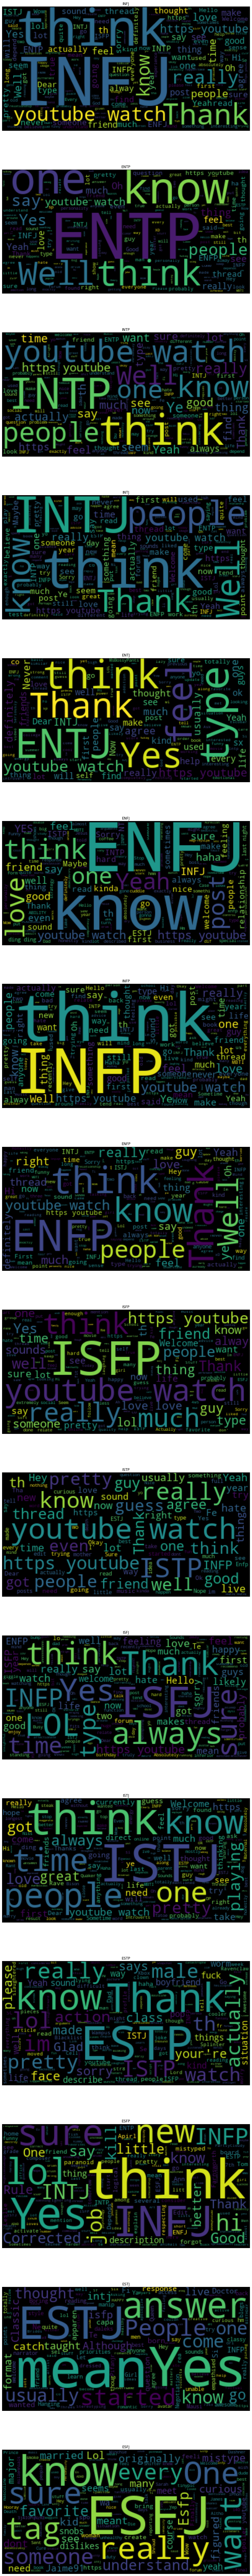

In [ ]:
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(len(data['type'].unique()), sharex=True, figsize=(15,10*len(data['type'].unique())))

k = 0
for i in data['type'].unique():
    text_4 = data[data['type'] == i]
    wordcloud = WordCloud().generate(text_4['posts'].to_string())
    ax[k].imshow(wordcloud, interpolation='bilinear')
    ax[k].axis("off")
    ax[k].set_title(i)
    k+=1


### Preprocessing posts

To normalize posts, we will be:

1. Converting all letters to lowercase.
2. Remove '|||'
3. Removing punctuations using regex.
4. Removing URLs, links etc ... using 
5. Convert words to integers

In [ ]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

### Function to clean the text data.

In [ ]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
        # Remove |||
        sentence=sentence.replace('|||',"") 

        # Remove URLs, links etc
        sentence = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', sentence, flags=re.MULTILINE) 

        # Remove puntuations 
        puncs1=['@','#','$','%','^','&','*','(',')','-','_','+','=','{','}','[',']','|','\\','"',"'",';',':','<','>','/']
        for punc in puncs1:
            sentence=sentence.replace(punc,'') 

        puncs2=[',','.','?','!','\n']
        for punc in puncs2:
            sentence=sentence.replace(punc,' ')
             
        # Remove extra white spaces
        sentence=re.sub( '\s+', ' ', sentence ).strip()
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [ ]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 6940/6940 [00:07<00:00, 868.19it/s]


In [ ]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 1735/1735 [00:21<00:00, 78.94it/s] 


In [ ]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

<h1 style="background-color:#99b3ff;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Tokenizing words</h1>

In [ ]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<__main__.Lemmatizer object at 0x7efdb3801050>,
                use_idf=True, vocabulary=None)

In [ ]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [ ]:
train_post.shape

(6940, 5000)

In [ ]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

<h1 style="background-color:#99b3ff;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 50px;padding: 5px">Model selection</h1>

In [ ]:
models_accuracy={}

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Logistic Regression</h4>

In [ ]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.85      0.14      0.25       152
        ENFP       0.81      0.64      0.71       540
        ENTJ       0.92      0.24      0.38       185
        ENTP       0.81      0.65      0.72       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.73      0.82      0.77      1176
        INFP       0.65      0.93      0.76      1465
        INTJ       0.73      0.79      0.76       873
        INTP       0.67      0.87      0.76      1043
        ISFJ       0.88      0.21      0.34       133
        ISFP       0.88      0.21      0.34       217
        ISTJ       0.83      0.24      0.37       164
        ISTP       0.90      0.49      0.64       270

    accuracy                           0.71      

In [ ]:
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       1.00      0.08      0.15        38
        ENFP       0.73      0.53      0.62       135
        ENTJ       0.67      0.13      0.22        46
        ENTP       0.61      0.49      0.54       137
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.64      0.72      0.68       294
        INFP       0.56      0.87      0.68       367
        INTJ       0.62      0.65      0.63       218
        INTP       0.65      0.82      0.72       261
        ISFJ       0.75      0.09      0.16        33
        ISFP       0.78      0.13      0.22        54
        ISTJ       0.60      0.07      0.13        41
        ISTP       0.66      0.34      0.45        67

    accuracy                           0.62      17

In [ ]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Decision Tree Classifier</h4>

In [ ]:
model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=14, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:

print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.62      0.50      0.55       152
        ENFP       0.93      0.78      0.85       540
        ENTJ       0.91      0.57      0.70       185
        ENTP       0.92      0.80      0.86       548
        ESFJ       1.00      0.38      0.55        34
        ESFP       0.71      0.26      0.38        38
        ESTJ       0.89      0.26      0.40        31
        ESTP       0.94      0.41      0.57        71
        INFJ       0.90      0.81      0.85      1176
        INFP       0.62      0.94      0.74      1465
        INTJ       0.86      0.84      0.85       873
        INTP       0.86      0.81      0.84      1043
        ISFJ       0.93      0.59      0.72       133
        ISFP       0.78      0.64      0.70       217
        ISTJ       0.78      0.60      0.68       164
        ISTP       0.94      0.67      0.79       270

    accuracy                           0.79      

In [ ]:
models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Random Forest Classifier</h4>

In [ ]:
model_forest=RandomForestClassifier(max_depth=10)
model_forest.fit(train_post,train_target)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:

print('train classification report \n ',classification_report(train_target,model_forest.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_forest.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.02      0.04       152
        ENFP       0.98      0.47      0.63       540
        ENTJ       1.00      0.06      0.12       185
        ENTP       0.96      0.59      0.73       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.03      0.05        71
        INFJ       0.81      0.84      0.83      1176
        INFP       0.47      0.99      0.64      1465
        INTJ       0.85      0.76      0.80       873
        INTP       0.78      0.88      0.82      1043
        ISFJ       1.00      0.03      0.06       133
        ISFP       1.00      0.05      0.10       217
        ISTJ       1.00      0.04      0.08       164
        ISTP       1.00      0.20      0.34       270

    accuracy                           0.68      

In [ ]:
models_accuracy['Random Forest Classifier']=accuracy_score(test_target,model_forest.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">KNN</h4>

In [ ]:
model_knn=KNeighborsRegressor(n_neighbors=1)
model_knn.fit(train_post,train_target)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')

In [ ]:
print('train classification report \n ',classification_report(train_target,model_knn.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_knn.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      1.00      1.00       152
        ENFP       1.00      1.00      1.00       540
        ENTJ       1.00      1.00      1.00       185
        ENTP       1.00      1.00      1.00       548
        ESFJ       1.00      1.00      1.00        34
        ESFP       1.00      1.00      1.00        38
        ESTJ       1.00      1.00      1.00        31
        ESTP       1.00      1.00      1.00        71
        INFJ       1.00      1.00      1.00      1176
        INFP       1.00      1.00      1.00      1465
        INTJ       1.00      1.00      1.00       873
        INTP       1.00      1.00      1.00      1043
        ISFJ       1.00      1.00      1.00       133
        ISFP       1.00      1.00      1.00       217
        ISTJ       1.00      1.00      1.00       164
        ISTP       1.00      1.00      1.00       270

    accuracy                           1.00      

In [ ]:
models_accuracy['KNN']=accuracy_score(test_target,model_knn.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Naive Bayes</h4>

In [ ]:
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       1.00      0.01      0.03       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.92      0.06      0.12       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.53      0.62      0.57      1176
        INFP       0.35      0.95      0.51      1465
        INTJ       0.78      0.42      0.55       873
        INTP       0.58      0.63      0.61      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       0.00      0.00      0.00       270

    accuracy                           0.46      

In [ ]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">CatBoot Classifier</h4>

In [ ]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
model_cat.fit(train_post,train_target)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_cat.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_cat.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.87      0.59      0.70       152
        ENFP       0.79      0.74      0.76       540
        ENTJ       0.90      0.62      0.73       185
        ENTP       0.79      0.76      0.77       548
        ESFJ       1.00      0.47      0.64        34
        ESFP       1.00      0.18      0.31        38
        ESTJ       1.00      0.29      0.45        31
        ESTP       0.95      0.52      0.67        71
        INFJ       0.79      0.83      0.81      1176
        INFP       0.78      0.89      0.83      1465
        INTJ       0.80      0.80      0.80       873
        INTP       0.75      0.86      0.80      1043
        ISFJ       0.93      0.64      0.76       133
        ISFP       0.85      0.65      0.73       217
        ISTJ       0.87      0.69      0.77       164
        ISTP       0.88      0.77      0.82       270

    accuracy                           0.79      

In [ ]:
models_accuracy['CatBoost Classifier']=accuracy_score(test_target,model_cat.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">XGBoost Classifier</h4>

In [ ]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1,task_type='GPU')
model_xgb.fit(train_post,train_target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, task_type='GPU', tree_method='gpu_hist',
              verbosity=1)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.99      0.93      0.96       152
        ENFP       0.96      0.91      0.93       540
        ENTJ       1.00      0.92      0.96       185
        ENTP       0.95      0.91      0.93       548
        ESFJ       1.00      0.97      0.99        34
        ESFP       1.00      0.92      0.96        38
        ESTJ       1.00      0.84      0.91        31
        ESTP       1.00      0.97      0.99        71
        INFJ       0.91      0.91      0.91      1176
        INFP       0.90      0.95      0.93      1465
        INTJ       0.91      0.91      0.91       873
        INTP       0.90      0.93      0.91      1043
        ISFJ       1.00      0.95      0.98       133
        ISFP       0.99      0.90      0.94       217
        ISTJ       0.99      0.95      0.97       164
        ISTP       0.98      0.94      0.96       270

    accuracy                           0.93      

In [ ]:
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">SVC</h4>

In [ ]:
model_svc=SVC()
model_svc.fit(train_post,train_target)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.97      0.84      0.90       152
        ENFP       0.97      0.95      0.96       540
        ENTJ       0.99      0.90      0.94       185
        ENTP       0.95      0.96      0.96       548
        ESFJ       1.00      0.56      0.72        34
        ESFP       1.00      0.34      0.51        38
        ESTJ       1.00      0.55      0.71        31
        ESTP       1.00      0.82      0.90        71
        INFJ       0.95      0.97      0.96      1176
        INFP       0.92      0.98      0.95      1465
        INTJ       0.96      0.97      0.96       873
        INTP       0.94      0.98      0.96      1043
        ISFJ       1.00      0.87      0.93       133
        ISFP       0.97      0.90      0.94       217
        ISTJ       0.94      0.92      0.93       164
        ISTP       0.98      0.93      0.96       270

    accuracy                           0.95      

In [ ]:
models_accuracy['Support Vector classifier']=accuracy_score(test_target,model_svc.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Linear SVC</h4>

In [ ]:
model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)

In [ ]:
print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))

### Comparing Models

In [ ]:
models_accuracy

In [ ]:
models_accuracy.keys()

In [ ]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])

In [ ]:
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

For Bencmark dataset, our best algorithm is 52%. 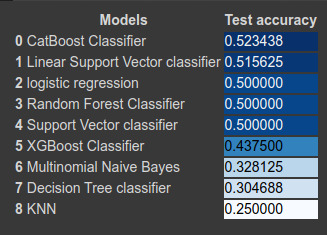

For our normal data set, our best algorithm is 66%.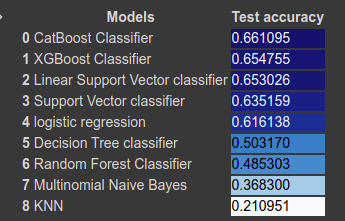